In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgbm

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,last_checkout_day_log,open_count_last_10_days_log,open_count_last_30_days_log,open_count_last_60_days_log,login_count_last_10_days_log,login_count_last_30_days_log,login_count_last_60_days_log,checkout_count_last_10_days_log,checkout_count_last_30_days_log,checkout_count_last_60_days_log
0,4,2019-07-16 00:00:00+08:00,43,44,19,6,18,0,2,4,...,2.944439,0.000000,1.098612,1.609438,2.564949,3.784190,4.605170,0.000000,1.791759,2.397895
1,4,2019-07-16 00:00:00+08:00,102,44,9,4,8,2,9,17,...,2.197225,1.098612,2.302585,2.890372,2.944439,3.891820,4.510860,0.693147,0.693147,1.609438
2,6,2019-07-16 00:00:00+08:00,177,49,14,5,5,0,4,12,...,1.791759,0.000000,1.609438,2.564949,3.218876,4.248495,4.787492,1.791759,2.995732,3.332205
3,1,2019-07-16 00:00:00+08:00,184,49,49,9,53,0,0,1,...,3.988984,0.000000,0.000000,0.693147,2.302585,3.178054,4.248495,0.693147,1.386294,1.945910
4,6,2019-07-16 00:00:00+08:00,221,49,227,6,221,0,0,0,...,5.402677,0.000000,0.000000,0.000000,1.098612,1.791759,1.791759,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71534,6,2019-09-02 00:00:00+08:00,127613,39,24,36,279,0,1,1,...,5.634790,0.000000,0.693147,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71535,2,2019-09-02 00:00:00+08:00,127620,38,46,10,51,0,0,1,...,3.951244,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71536,2,2019-09-02 00:00:00+08:00,127696,32,808,18141,1445,0,0,0,...,7.276556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71537,2,2019-09-02 00:00:00+08:00,127807,38,5,34,1445,2,4,4,...,7.276556,1.098612,1.609438,1.609438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [3]:
train.columns

Index(['country_code', 'grass_date', 'user_id', 'subject_line_length',
       'last_open_day', 'last_login_day', 'last_checkout_day',
       'open_count_last_10_days', 'open_count_last_30_days',
       'open_count_last_60_days', 'login_count_last_10_days',
       'login_count_last_30_days', 'login_count_last_60_days',
       'checkout_count_last_10_days', 'checkout_count_last_30_days',
       'checkout_count_last_60_days', 'open_flag', 'row_id', 'attr_1',
       'attr_2', 'attr_3', 'age', 'domain', 'day_of_week', 'last_open_day_log',
       'last_login_day_log', 'last_checkout_day_log',
       'open_count_last_10_days_log', 'open_count_last_30_days_log',
       'open_count_last_60_days_log', 'login_count_last_10_days_log',
       'login_count_last_30_days_log', 'login_count_last_60_days_log',
       'checkout_count_last_10_days_log', 'checkout_count_last_30_days_log',
       'checkout_count_last_60_days_log'],
      dtype='object')

open_flag
0    61083
1    10456
Name: country_code, dtype: int64


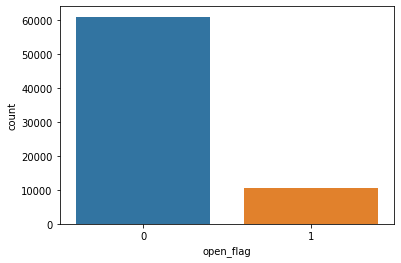

In [4]:
sns.countplot('open_flag', data=train)
print(train.groupby('open_flag').count()['country_code'])

open_flag
0    30000
1    30000
Name: country_code, dtype: int64


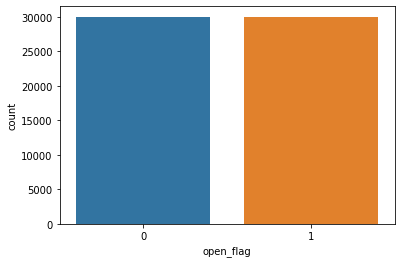

In [5]:
TRAIN_SIZE = 30000

df0 = train[train['open_flag'] == 0]
df0 = df0.sample(TRAIN_SIZE, random_state=0)

df1 = train[train['open_flag'] == 1]
df1 = df1.append(df1, ignore_index=True)
df1 = df1.append(df1, ignore_index=True)
df1 = df1.sample(TRAIN_SIZE, random_state=0)

train_resampled = pd.concat((df0, df1), ignore_index=True)

sns.countplot('open_flag', data=train_resampled)
print(train_resampled.groupby('open_flag').count()['country_code'])

In [6]:
def target_encoder(df, feature, label):
    ranking = df.groupby(feature).apply(lambda x: x[label].sum() / x[label].count())
    ranking = ranking.sort_values()

    encoder = {x: i for i, x in enumerate(ranking.index)}
    decoder = {i: x for i, x in enumerate(ranking.index)}
    return encoder, decoder

target_encoder(train_resampled, 'country_code', 'open_flag')

({1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6},
 {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4})

In [7]:
all_encoders = {}
all_decoders = {}

for x in ['country_code', 'domain', 'day_of_week']:
    encoder, decoder = target_encoder(train, x, 'open_flag')
    all_encoders[x] = encoder
    all_decoders[x] = decoder

    train_resampled[x + '_encoded'] = train_resampled[x].map(encoder)
    test[x + '_encoded'] = test[x].map(encoder)

print(all_encoders)
print(all_decoders)

{'country_code': {1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6}, 'domain': {'@gmail.com': 0, '@163.com': 1, '@yahoo.com': 2, '@ymail.com': 3, '@rocketmail.com': 4, '@outlook.com': 5, '@qq.com': 6, '@live.com': 7, '@icloud.com': 8, '@hotmail.com': 9, 'other': 10}, 'day_of_week': {5: 0, 1: 1, 0: 2, 3: 3, 6: 4, 4: 5, 2: 6}}
{'country_code': {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4}, 'domain': {0: '@gmail.com', 1: '@163.com', 2: '@yahoo.com', 3: '@ymail.com', 4: '@rocketmail.com', 5: '@outlook.com', 6: '@qq.com', 7: '@live.com', 8: '@icloud.com', 9: '@hotmail.com', 10: 'other'}, 'day_of_week': {0: 5, 1: 1, 2: 0, 3: 3, 4: 6, 5: 4, 6: 2}}


In [8]:
for x in ['10', '30', '60']:
    train_resampled['engine' + x] = (train_resampled[f'checkout_count_last_{x}_days'] + 1) / (train_resampled[f'login_count_last_{x}_days'] + 1)
    test['engine' + x] = (test[f'checkout_count_last_{x}_days'] + 1) / (test[f'login_count_last_{x}_days'] + 1)


In [9]:
OLC = ('open', 'login', 'checkout')
DAYS = (10, 30, 60)

encoded_features = \
    ['subject_line_length'] + \
    [f'last_{x}_day' for x in OLC] + \
    [f'last_{x}_day_log' for x in OLC] + \
    [f'{x}_count_last_{y}_days' for x in OLC for y in DAYS] + \
    [f'{x}_count_last_{y}_days_log' for x in OLC for y in DAYS] + \
    ['engine10', 'engine30', 'engine60'] + \
    ['attr_1', 'attr_2', 'attr_3'] + \
    ['country_code_encoded', 'domain_encoded', 'day_of_week_encoded']

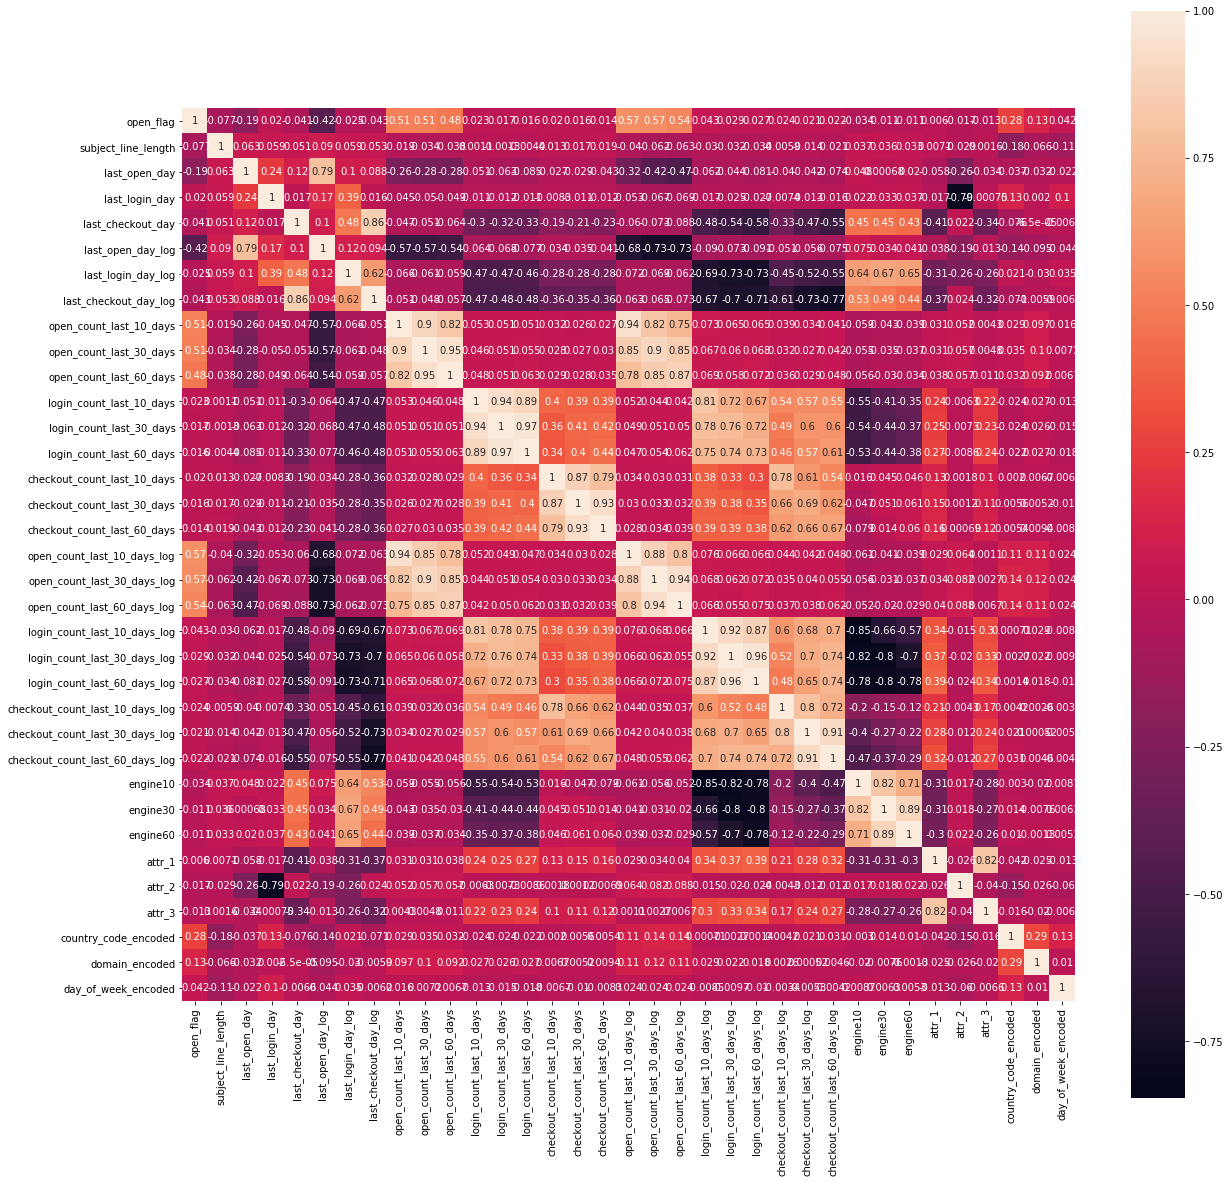

In [10]:
plt.figure(figsize=(20,20))
sns.heatmap(
    train_resampled.loc[:, ['open_flag'] + encoded_features].corr(), 
    square=True, annot=True
)

In [11]:
inputs = train_resampled.loc[:, encoded_features]
test_inputs = test.loc[:, encoded_features]

labels = train_resampled['open_flag']
test_labels = test['open_flag']

In [12]:
scale = StandardScaler()
inputs = scale.fit_transform(inputs)
test_inputs = scale.transform(test_inputs)

inputs

array([[-0.45444207, -0.20069689, -0.10842723, ..., -0.01009602,
        -0.38843649,  1.63807878],
       [ 0.17346336, -0.336412  , -0.10692654, ...,  1.95985826,
         3.01447887, -1.65498317],
       [-0.18533974, -0.17261791, -0.10767689, ...,  0.97488112,
         2.25827546, -0.00845219],
       ...,
       [-0.7235444 , -0.38789014, -0.10767689, ...,  1.95985826,
        -0.38843649,  1.63807878],
       [-0.18533974, -0.38789014, -0.097172  , ...,  0.97488112,
         3.39258058, -0.00845219],
       [-0.00593819, -0.3223725 ,  0.04914599, ..., -0.01009602,
        -0.38843649, -1.10613951]])

In [13]:
def test_model(model, inputs, labels, test_inputs, test_labels):
    print('Doing cross-validation...')
    cv_acc = cross_val_score(model, inputs, labels)
    print('CV accuracy: ', cv_acc, np.mean(cv_acc))

    print('Training model...')
    model.fit(inputs, labels)
    preds = model.predict(test_inputs)

    sns.heatmap(confusion_matrix(test_labels, preds), annot=True, fmt="d")
    print('Test accuracy: ', accuracy_score(test_labels, preds))
    print('Test Matthews: ', matthews_corrcoef(test_labels, preds))

    return model

Doing cross-validation...
CV accuracy:  [0.93358333 0.931      0.92833333 0.93141667 0.93225   ] 0.9313166666666668
Training model...
Test accuracy:  0.763
Test Matthews:  0.5489289731312628


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

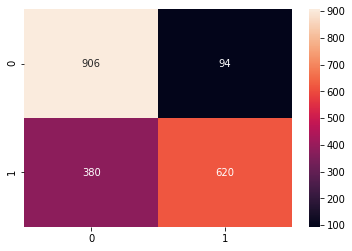

In [14]:
forest = RandomForestClassifier()
test_model(forest, inputs, labels, test_inputs, test_labels)

Doing cross-validation...
CV accuracy:  [0.80133333 0.79358333 0.79616667 0.79291667 0.79633333] 0.7960666666666667
Training model...
Test accuracy:  0.793
Test Matthews:  0.5878842492355063


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

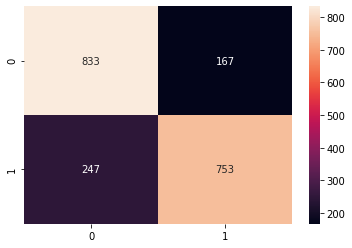

In [15]:
gbc = GradientBoostingClassifier()
test_model(gbc, inputs, labels, test_inputs, test_labels)

Doing cross-validation...
CV accuracy:  [0.84733333 0.84116667 0.84383333 0.84216667 0.83975   ] 0.84285
Training model...
Test accuracy:  0.793
Test Matthews:  0.5890723665703587


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

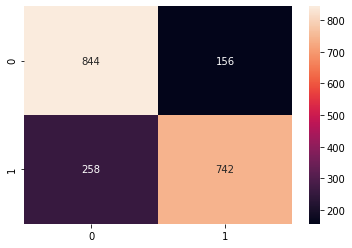

In [16]:
xgb_forest = XGBClassifier()
test_model(xgb_forest, inputs, labels, test_inputs, test_labels)

Doing cross-validation...
CV accuracy:  [0.81416667 0.81108333 0.81308333 0.81041667 0.81191667] 0.8121333333333334
Training model...
Test accuracy:  0.802
Test Matthews:  0.6052408050568846


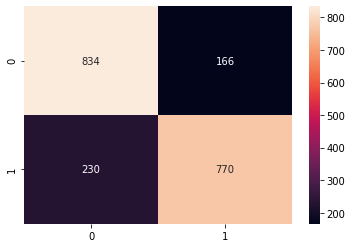

In [15]:
cat_clf = CatBoostClassifier(task_type='GPU', verbose=0)
test_model(cat_clf, inputs, labels, test_inputs, test_labels)


In [17]:
num_features = \
    ['subject_line_length'] + \
    [f'last_{x}_day' for x in OLC] + \
    [f'last_{x}_day_log' for x in OLC] + \
    [f'{x}_count_last_{y}_days' for x in OLC for y in DAYS] + \
    [f'{x}_count_last_{y}_days_log' for x in OLC for y in DAYS] + \
    ['engine10', 'engine30', 'engine60']

cat_features = [
    'attr_1', 'attr_2', 'attr_3',
    'country_code', 'domain', 'day_of_week'
]

In [18]:
num_inputs = train_resampled.loc[:, num_features]
cat_inputs = train_resampled.loc[:, cat_features]

test_num_inputs = test.loc[:, num_features]
test_cat_inputs = test.loc[:, cat_features]

for x in ['attr_1', 'attr_2', 'attr_3']:
    cat_inputs[x] = cat_inputs[x].astype(int)
    test_cat_inputs[x] = test_cat_inputs[x].astype(int)

num_scaler = StandardScaler()
num_inputs = num_scaler.fit_transform(num_inputs)
test_num_inputs = num_scaler.transform(test_num_inputs)

In [19]:
cbc_inputs = np.hstack((num_inputs, cat_inputs.to_numpy()))
test_cbc_inputs = np.hstack((test_num_inputs, test_cat_inputs.to_numpy()))

print('Shape of numerical inputs: ', num_inputs.shape)
print('Shape of categorical inputs: ', cat_inputs.shape)
print('Shape of combined inputs: ', cbc_inputs.shape)

Shape of numerical inputs:  (60000, 28)
Shape of categorical inputs:  (60000, 6)
Shape of combined inputs:  (60000, 34)


In [20]:
cat_clf = CatBoostClassifier(task_type='GPU')
cat_idx = [28+i for i in range(6)]
cat_clf.fit(cbc_inputs, labels, cat_features=cat_idx, eval_set=(test_cbc_inputs, test_labels))

3s
778:	learn: 0.4001999	test: 0.4386583	best: 0.4376401 (432)	total: 12.4s	remaining: 3.52s
779:	learn: 0.4001495	test: 0.4386978	best: 0.4376401 (432)	total: 12.4s	remaining: 3.5s
780:	learn: 0.4001401	test: 0.4387195	best: 0.4376401 (432)	total: 12.4s	remaining: 3.48s
781:	learn: 0.4001186	test: 0.4387421	best: 0.4376401 (432)	total: 12.4s	remaining: 3.47s
782:	learn: 0.4000796	test: 0.4387535	best: 0.4376401 (432)	total: 12.5s	remaining: 3.45s
783:	learn: 0.4000665	test: 0.4387806	best: 0.4376401 (432)	total: 12.5s	remaining: 3.44s
784:	learn: 0.4000499	test: 0.4387625	best: 0.4376401 (432)	total: 12.5s	remaining: 3.42s
785:	learn: 0.4000248	test: 0.4387556	best: 0.4376401 (432)	total: 12.5s	remaining: 3.41s
786:	learn: 0.3998948	test: 0.4386856	best: 0.4376401 (432)	total: 12.5s	remaining: 3.39s
787:	learn: 0.3998478	test: 0.4387001	best: 0.4376401 (432)	total: 12.5s	remaining: 3.38s
788:	learn: 0.3997702	test: 0.4387018	best: 0.4376401 (432)	total: 12.6s	remaining: 3.36s
789:	lea

In [21]:
preds = cat_clf.predict(test_cbc_inputs)
print('Test accuracy: ', accuracy_score(test_labels, preds))
print('Test Matthews: ', matthews_corrcoef(test_labels, preds))

Test accuracy:  0.7935
Test Matthews:  0.5880243485952232


In [25]:
kaggle_test = pd.read_csv('test_kaggle.csv')
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,last_checkout_day_log,open_count_last_10_days_log,open_count_last_30_days_log,open_count_last_60_days_log,login_count_last_10_days_log,login_count_last_30_days_log,login_count_last_60_days_log,checkout_count_last_10_days_log,checkout_count_last_30_days_log,checkout_count_last_60_days_log
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,2.639057,1.098612,1.386294,1.609438,2.397895,3.555348,4.905275,0.000000,1.945910,2.944439
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,5.950643,0.693147,0.693147,0.693147,1.791759,1.791759,1.791759,0.000000,0.000000,0.000000
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,1.386294,0.000000,0.000000,0.000000,2.639057,2.995732,3.663562,1.098612,1.098612,1.098612
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,1.791759,0.000000,0.000000,0.000000,3.784190,4.709530,5.159055,1.098612,1.791759,1.791759
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,4.007333,0.000000,0.000000,0.000000,1.609438,2.564949,3.688879,0.000000,0.000000,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,2.197225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,7.096721,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,7.276556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,1.945910,1.098612,1.791759,2.708050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
for feature, encoder in all_encoders.items():
    kaggle_test[feature + '_encoded'] = kaggle_test[feature].map(encoder)

for x in ['10', '30', '60']:
    kaggle_test['engine' + x] = (kaggle_test[f'checkout_count_last_{x}_days'] + 1) / (kaggle_test[f'login_count_last_{x}_days'] + 1)

kaggle_inputs = kaggle_test.loc[:, encoded_features]
kaggle_inputs = scale.transform(kaggle_inputs)

In [28]:
kaggle_preds = forest.predict(kaggle_inputs)
kaggle_test['open_flag'] = kaggle_preds
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,checkout_count_last_10_days_log,checkout_count_last_30_days_log,checkout_count_last_60_days_log,country_code_encoded,domain_encoded,day_of_week_encoded,engine10,engine30,engine60,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.000000,1.945910,2.944439,4,0,1,0.090909,0.200000,0.140741,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.000000,0.000000,0.000000,4,0,1,0.166667,0.166667,0.166667,0
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,1.098612,1.098612,1.098612,3,0,1,0.214286,0.150000,0.076923,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,1.098612,1.791759,1.791759,0,2,1,0.068182,0.054054,0.034483,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.000000,0.000000,1.098612,3,0,1,0.200000,0.076923,0.075000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,0.000000,0.000000,0.000000,4,0,4,1.000000,1.000000,1.000000,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,0.000000,0.000000,0.000000,4,0,4,1.000000,1.000000,1.000000,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,0.000000,0.000000,0.000000,4,9,4,1.000000,1.000000,1.000000,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,0.000000,0.000000,0.000000,4,0,4,1.000000,1.000000,1.000000,1


In [29]:
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_forest.csv', index=False)

In [32]:
kaggle_preds = gbc.predict(kaggle_inputs)
kaggle_test['open_flag'] = kaggle_preds
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,checkout_count_last_10_days_log,checkout_count_last_30_days_log,checkout_count_last_60_days_log,country_code_encoded,domain_encoded,day_of_week_encoded,engine10,engine30,engine60,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.000000,1.945910,2.944439,4,0,1,0.090909,0.200000,0.140741,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.000000,0.000000,0.000000,4,0,1,0.166667,0.166667,0.166667,0
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,1.098612,1.098612,1.098612,3,0,1,0.214286,0.150000,0.076923,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,1.098612,1.791759,1.791759,0,2,1,0.068182,0.054054,0.034483,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.000000,0.000000,1.098612,3,0,1,0.200000,0.076923,0.075000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,0.000000,0.000000,0.000000,4,0,4,1.000000,1.000000,1.000000,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,0.000000,0.000000,0.000000,4,0,4,1.000000,1.000000,1.000000,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,0.000000,0.000000,0.000000,4,9,4,1.000000,1.000000,1.000000,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,0.000000,0.000000,0.000000,4,0,4,1.000000,1.000000,1.000000,1


In [33]:
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_gbc.csv', index=False)

In [39]:
kaggle_preds = xgb_forest.predict(kaggle_inputs)
kaggle_test['open_flag'] = kaggle_preds
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,login_count_last_10_days_log,login_count_last_30_days_log,login_count_last_60_days_log,checkout_count_last_10_days_log,checkout_count_last_30_days_log,checkout_count_last_60_days_log,country_code_encoded,domain_encoded,day_of_week_encoded,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,2.397895,3.555348,4.905275,0.000000,1.945910,2.944439,4,0,1,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,1.791759,1.791759,1.791759,0.000000,0.000000,0.000000,4,0,1,1
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,2.639057,2.995732,3.663562,1.098612,1.098612,1.098612,3,0,1,1
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,3.784190,4.709530,5.159055,1.098612,1.791759,1.791759,0,2,1,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,1.609438,2.564949,3.688879,0.000000,0.000000,1.098612,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,4,1
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,4,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,9,4,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,4,1


In [40]:
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_xgb.csv', index=False)

In [35]:
kaggle_preds = cat_clf.predict(kaggle_inputs)
kaggle_test['open_flag'] = kaggle_preds
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,checkout_count_last_10_days_log,checkout_count_last_30_days_log,checkout_count_last_60_days_log,country_code_encoded,domain_encoded,day_of_week_encoded,engine10,engine30,engine60,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.000000,1.945910,2.944439,4,0,1,0.090909,0.200000,0.140741,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.000000,0.000000,0.000000,4,0,1,0.166667,0.166667,0.166667,0
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,1.098612,1.098612,1.098612,3,0,1,0.214286,0.150000,0.076923,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,1.098612,1.791759,1.791759,0,2,1,0.068182,0.054054,0.034483,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.000000,0.000000,1.098612,3,0,1,0.200000,0.076923,0.075000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,0.000000,0.000000,0.000000,4,0,4,1.000000,1.000000,1.000000,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,0.000000,0.000000,0.000000,4,0,4,1.000000,1.000000,1.000000,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,0.000000,0.000000,0.000000,4,9,4,1.000000,1.000000,1.000000,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,0.000000,0.000000,0.000000,4,0,4,1.000000,1.000000,1.000000,1


In [36]:
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_cat.csv', index=False)